
# Code to run the file in SageMaker

In [ ]:
#Install the CLI
import sys

!{sys.executable} -m pip install sagemaker_studio_image_build

In [ ]:
# Add IAM Permissions to the current SageMaker Execution Role.
import sagemaker
import boto3

try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Pending do it on Sagemaker:
Update Trust Policy for CodeBuild

Open IAM and search for the role listed above. (https://console.aws.amazon.com/iamv2/home?#/roles)
Select the Role and click on the Trust relationships tab.
Update the trust relationship using the JSON to establish a trust relationship with CodeBuild

{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Principal": {
        "Service": "sagemaker.amazonaws.com"
      },
      "Action": "sts:AssumeRole"
    },
    {
      "Effect": "Allow",
      "Principal": {
        "Service": [
          "codebuild.amazonaws.com"
        ]
      },
      "Action": "sts:AssumeRole"
    }
  ]
}

Once you've added the trust relationship above, click Update Trust Policy

We also need to add some additional permissions to the execution role to be able to build the image with CodeBuild and push the image to ECR. You can update the existing execution policy attached to the role or create a new policy and attach it to the existing execution role. Whichever option you choose, ensure the policy has the correct permissions set for intended S3 bucket access. The sample policy in the CLI README assumes access to the default session bucket so this may need to be modified for your use casee. For this example, we are going to create a new policy and attach it to the existing role.
Create policy allowing access to supporting services
Open Policies in IAM (https://console.aws.amazon.com/iamv2/home#/policies)
Click Create policy
Select the JSON tab and copy/paste the policy below

{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "codebuild:DeleteProject",
                "codebuild:CreateProject",
                "codebuild:BatchGetBuilds",
                "codebuild:StartBuild"
            ],
            "Resource": "arn:aws:codebuild:*:*:project/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": "logs:CreateLogStream",
            "Resource": "arn:aws:logs:*:*:log-group:/aws/codebuild/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "logs:GetLogEvents",
                "logs:PutLogEvents"
            ],
            "Resource": "arn:aws:logs:*:*:log-group:/aws/codebuild/sagemaker-studio*:log-stream:*"
        },
        {
            "Effect": "Allow",
            "Action": "logs:CreateLogGroup",
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "ecr:CreateRepository",
                "ecr:BatchGetImage",
                "ecr:CompleteLayerUpload",
                "ecr:DescribeImages",
                "ecr:DescribeRepositories",
                "ecr:UploadLayerPart",
                "ecr:ListImages",
                "ecr:InitiateLayerUpload",
                "ecr:BatchCheckLayerAvailability",
                "ecr:PutImage"
            ],
            "Resource": "arn:aws:ecr:*:*:repository/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": "ecr:GetAuthorizationToken",
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
              "s3:GetObject",
              "s3:DeleteObject",
              "s3:PutObject"
              ],
            "Resource": "arn:aws:s3:::sagemaker-*/*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "s3:CreateBucket"
            ],
            "Resource": "arn:aws:s3:::sagemaker*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "iam:GetRole",
                "iam:ListRoles"
            ],
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": "iam:PassRole",
            "Resource": "arn:aws:iam::*:role/*",
            "Condition": {
                "StringLikeIfExists": {
                    "iam:PassedToService": "codebuild.amazonaws.com"
                }
            }
        }
    ]
}


Click Review policy
Give the policy a name such as Studio-Image-Build-Policy
Click Create policy


We now need to attach our policy to the Execution Role attached to this notebook environment.
Go back to Roles in IAM (https://console.aws.amazon.com/iamv2/home#/roles)
Select the SageMaker Execution Role from abovee
On the Permissions tab, click Attach policies
Search for the Policy we created above Studio-Image-Build-Policy
Select the policy and click Attach policy



Step 3: Building and registering the container using the SageMaker Studio Image Build CLI
    We will now create our training container image, using the SageMaker Studio Image Build CLI
To do this we need to navigate to the directory containing our Dockerfile and simply execute the build command:
              sm-docker build .
The build command can optionally take additional arguments depending on your needs:
              sm-docker build . --file /path/to/Dockerfile --build-arg foo=bar
TIP If you receive a permissions error below, please ensure you have completed both permission setup items above: (1) Update Trust Policy (2) Create new policy & Attach it to the existing SageMaker Execution Role

!sm-docker build .

## EDA


In [7]:
#Common packages:
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
import os
os.getcwd()

'/Users/jose1/Desktop/SpringboardLalli/PROJECT_2/P2_Earthquake'

In [5]:
#Print the files in your current directory to make sure the 'updated_ski_data.csv' is present.
os.listdir()

['.ipynb_checkpoints',
 '.train.csv.icloud',
 'tensorflow_bring_your_own.ipynb-Copy1.ipynb',
 'tensorflow_bring_your_own.ipynb.ipynb',
 'Test P2 Earthquake.ipynb',
 'Untitled.ipynb',
 'Untitled1.ipynb']

To do EDA I will take a sample of the first 100 million data.

In [13]:
#try:
train_data = pd.read_csv('train.csv',nrows=100000000, dtype={'acoustic_data': np.int16},error_bad_lines=False)
                           #nrows=100000000, dtype={'acoustic_data': np.int16})
                           #index_col=0)
 # print('Success: Data loaded into dataframe.')
print("Dataframe shape:", train_data .shape)
#except Exception as e:
 #   print('Data load error: ',e)

Dataframe shape: (100000000, 2)


In [4]:
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
from tqdm import tqdm
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error

In [ ]:
#!pip install s3fs #This line of code need to be executed only during the first run and can be avoided for subsequent runs

In [ ]:
#train = pd.read_csv("train.csv", dtype={'acoustic_data': np.int16})

In [17]:
pd.options.display.precision = 12
train_data.head(10)



,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [18]:
train_data.describe()

,acoustic_data,time_to_failure
count,1.000000e+08,1.000000e+08
mean,4.648496e+00,6.447961e+00
std,1.041905e+01,3.842484e+00
min,-4.621000e+03,6.954822e-04
25%,2.000000e+00,3.120298e+00
50%,5.000000e+00,6.366700e+00
75%,7.000000e+00,9.613998e+00
max,3.914000e+03,1.418060e+01


In [24]:
#train_data.acoustic_data.nunique()
train_data['acoustic_data_type'] = pd.Categorical(train_data.acoustic_data)

train_data.dtypes




acoustic_data            int16
time_to_failure        float64
acoustic_data_type    category
dtype: object

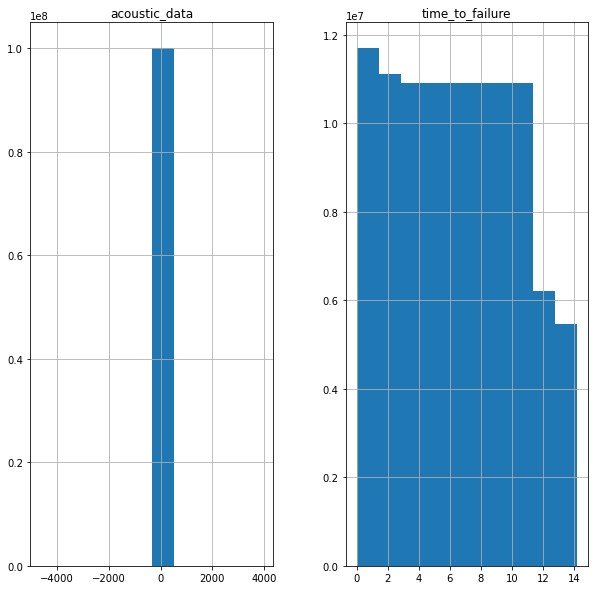

In [28]:
#histograms for each variable in df
hist_train = train_data.hist(bins=10,figsize =(10,10))

/Users/jose1/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


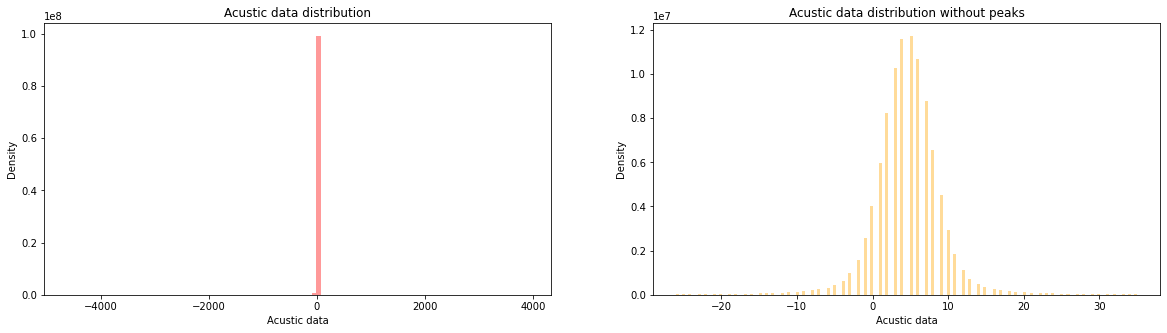

In [32]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(train_data.acoustic_data.values, ax=ax[0], color="Red", bins=100, kde=False)
ax[0].set_xlabel("Acustic data")
ax[0].set_ylabel("Density")
ax[0].set_title("Acustic data distribution")

low = train_data.acoustic_data.mean() - 3 * train_data.acoustic_data.std()
high = train_data.acoustic_data.mean() + 3 * train_data.acoustic_data.std() 
sns.distplot(train_data.loc[(train_data.acoustic_data >= low) & (train_data.acoustic_data <= high), "acoustic_data"].values,
             ax=ax[1],
             color="Orange",
             bins=150, kde=False)
ax[1].set_xlabel("Acustic data")
ax[1].set_ylabel("Density")
ax[1].set_title("Acustic data distribution without peaks");

In [35]:
#Helper function to graph acoustic data with time to failure.
def make_dualline(df):
    fig, ax1 = plt.subplots()
    plt.title('Acoustic Data and Time to Failure', fontsize=30)

    color = 'tab:orange'
    ax1.set_xlabel('index', fontsize=25)
    ax1.set_ylabel('Time to Failure', color=color, fontsize=20)
    
    ax1.plot(df['time_to_failure'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Acoustic Data', color=color, fontsize=20)  # we already handled the x-label with ax1
    ax2.plot(df['acoustic_data'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()



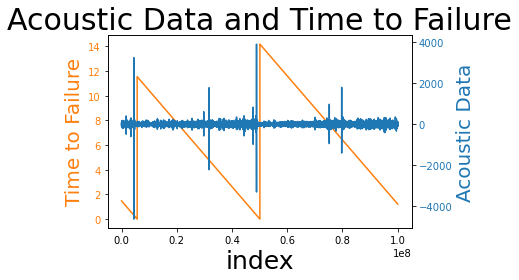

In [36]:
make_dualline(train_data)

In [27]:
#Print the percent of unique values per column. Use the df.nunique and the size of the dataframe to calculate 
#the percentages.
total=len(train_data)
print(total)
train_unique=train_data.nunique()
percentage_unique=train_unique/total
print(train_unique)
print(percentage_unique)

100000000
acoustic_data             3119
time_to_failure       99620548
acoustic_data_type        3119
dtype: int64
acoustic_data         0.000031
time_to_failure       0.996205
acoustic_data_type    0.000031
dtype: float64


In [22]:
#Run the code below to print out the percent of each feature that is missing.
nas=pd.DataFrame(train_data.isnull().sum().sort_values(ascending=False)/len(train_data),columns = ['percent'])
pos = nas['percent'] > 0
nas[pos]

,percent


# Analysis with 3.17% of the data (20 million readings)

In [17]:
#try:
train_short = pd.read_csv('train.csv',nrows=20000000, dtype={'acoustic_data': np.int16},error_bad_lines=False)
                           #nrows=100000000, dtype={'acoustic_data': np.int16})
                           #index_col=0)
 # print('Success: Data loaded into dataframe.')
print("Dataframe shape:", train_short .shape)
#except Exception as e:
 #   print('Data load error: ',e)
#train_short=train_whole.head(2000000)

Dataframe shape: (20000000, 2)


In [18]:
# First Segment
rows = 50000
idlist = []
for n in range(1,401):  #400 segments
    idlist = idlist + [n for i in range(rows)]



In [19]:
train_short['id']=idlist
print(train_short.head())    
train_short.tail()

   acoustic_data  time_to_failure  id
0             12           1.4691   1
1              6           1.4691   1
2              8           1.4691   1
3              5           1.4691   1
4              8           1.4691   1


,acoustic_data,time_to_failure,id
19999995,5,7.815696,400
19999996,2,7.815696,400
19999997,0,7.815696,400
19999998,4,7.815696,400
19999999,4,7.815696,400


In [20]:
y_all = train_short['time_to_failure']
x = train_short.drop(columns = 'time_to_failure')

In [21]:
len(y)

20000000

In [25]:
y_all.to_csv('y_all.csv', index=False)

In [22]:
len(x)

20000000

In [23]:
 x['time'] = x.index


In [24]:
x.head()

,acoustic_data,id,time
0,12,1,0
1,6,1,1
2,8,1,2
3,5,1,3
4,8,1,4


In [21]:
#TSFRESH Extract full features using 'x' as independent data set
extracted_features = extract_features(x, column_id="id", column_sort="time", default_fc_parameters=EfficientFCParameters())



Feature Extraction: 100%|██████████| 20/20 [3:18:08<00:00, 594.40s/it]   


In [22]:
extracted_features.head()

,acoustic_data__variance_larger_than_standard_deviation,acoustic_data__has_duplicate_max,acoustic_data__has_duplicate_min,acoustic_data__has_duplicate,acoustic_data__sum_values,acoustic_data__abs_energy,acoustic_data__mean_abs_change,acoustic_data__mean_change,acoustic_data__mean_second_derivative_central,acoustic_data__median,...,acoustic_data__permutation_entropy__dimension_5__tau_1,acoustic_data__permutation_entropy__dimension_6__tau_1,acoustic_data__permutation_entropy__dimension_7__tau_1,acoustic_data__query_similarity_count__query_None__threshold_0.0,"acoustic_data__matrix_profile__feature_""min""__threshold_0.98","acoustic_data__matrix_profile__feature_""max""__threshold_0.98","acoustic_data__matrix_profile__feature_""mean""__threshold_0.98","acoustic_data__matrix_profile__feature_""median""__threshold_0.98","acoustic_data__matrix_profile__feature_""25""__threshold_0.98","acoustic_data__matrix_profile__feature_""75""__threshold_0.98"
1,1.0,0.0,0.0,1.0,248105.0,-6191.0,2.750695,-0.00012,0.00012,5.0,...,4.443346,6.013180,7.652840,NaN,1.410740,7.186709,4.897440,5.124094,4.176964,5.794968
2,1.0,1.0,0.0,1.0,253489.0,-18533.0,2.589732,0.00008,-0.00001,5.0,...,4.504612,6.114078,7.801334,NaN,1.328854,6.607725,4.919248,5.178234,4.424988,5.619227
3,1.0,0.0,0.0,1.0,231023.0,-30565.0,2.499170,-0.00004,-0.00004,5.0,...,4.534089,6.164519,7.873629,NaN,1.116887,4.578974,3.155293,3.264616,2.838886,3.574419
4,1.0,1.0,0.0,1.0,234920.0,-29072.0,2.735615,0.00028,-0.00004,5.0,...,4.447336,6.025315,7.673619,NaN,1.460577,6.890946,4.823323,5.124911,4.023821,5.703971
5,1.0,0.0,0.0,1.0,234528.0,26818.0,2.730395,-0.00014,0.00009,5.0,...,4.494589,6.099774,7.781758,NaN,1.683005,8.460816,6.540426,6.939950,5.916377,7.462022


In [23]:
extracted_features.to_csv('extracted_features.csv', index=False)

In [27]:
extracted_features.columns

Index(['acoustic_data__variance_larger_than_standard_deviation',
       'acoustic_data__has_duplicate_max', 'acoustic_data__has_duplicate_min',
       'acoustic_data__has_duplicate', 'acoustic_data__sum_values',
       'acoustic_data__abs_energy', 'acoustic_data__mean_abs_change',
       'acoustic_data__mean_change',
       'acoustic_data__mean_second_derivative_central',
       'acoustic_data__median',
       ...
       'acoustic_data__permutation_entropy__dimension_5__tau_1',
       'acoustic_data__permutation_entropy__dimension_6__tau_1',
       'acoustic_data__permutation_entropy__dimension_7__tau_1',
       'acoustic_data__query_similarity_count__query_None__threshold_0.0',
       'acoustic_data__matrix_profile__feature_"min"__threshold_0.98',
       'acoustic_data__matrix_profile__feature_"max"__threshold_0.98',
       'acoustic_data__matrix_profile__feature_"mean"__threshold_0.98',
       'acoustic_data__matrix_profile__feature_"median"__threshold_0.98',
       'acoustic_data__m

In [37]:
len(extracted_features)

400

In [26]:
#I will get the max value of time to failure in each window. train_short
import time
start_time = time.time()
train_max = train_short[train_short['time_to_failure'] == train_short.groupby(['id'])['time_to_failure'].transform(max)]
print("---4 ) %s seconds ---" % (time.time() - start_time))


#start_time = time.time()
#y_max = df[df['B'] == df.groupby(['A'])['B'].transform(max)]
#print("---4 ) %s seconds ---" % (time.time() - start_time))

---4 ) 1.6792230606079102 seconds ---


In [27]:
len(train_max)

400

In [28]:
print(train_max.head())
print(train_max.tail())

        acoustic_data  time_to_failure  id
0                  12         1.469100   1
50000               1         1.456399   2
100000              2         1.443598   3
150000              5         1.430797   4
200000             18         1.418096   5
          acoustic_data  time_to_failure   id
19750000             11         7.880596  396
19800000              4         7.867896  397
19850000              6         7.853999  398
19900000              5         7.841298  399
19950000              8         7.828497  400


In [29]:
y=train_max['time_to_failure'].reset_index(drop=True)

In [30]:
y.to_csv('y_max.csv', index=False)

In [31]:
y.head()

0    1.469100
1    1.456399
2    1.443598
3    1.430797
4    1.418096
Name: time_to_failure, dtype: float64

In [28]:
#Before looking for a smaller set of important features, we need to impute the long list of features first.
impute(extracted_features)

/Users/jose1/opt/anaconda3/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:171: RuntimeWarning: The columns ['acoustic_data__friedrich_coefficients__coeff_0__m_3__r_30'
 'acoustic_data__friedrich_coefficients__coeff_1__m_3__r_30'
 'acoustic_data__friedrich_coefficients__coeff_2__m_3__r_30'
 'acoustic_data__friedrich_coefficients__coeff_3__m_3__r_30'
 'acoustic_data__max_langevin_fixed_point__m_3__r_30'
 'acoustic_data__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(


,acoustic_data__variance_larger_than_standard_deviation,acoustic_data__has_duplicate_max,acoustic_data__has_duplicate_min,acoustic_data__has_duplicate,acoustic_data__sum_values,acoustic_data__abs_energy,acoustic_data__mean_abs_change,acoustic_data__mean_change,acoustic_data__mean_second_derivative_central,acoustic_data__median,...,acoustic_data__permutation_entropy__dimension_5__tau_1,acoustic_data__permutation_entropy__dimension_6__tau_1,acoustic_data__permutation_entropy__dimension_7__tau_1,acoustic_data__query_similarity_count__query_None__threshold_0.0,"acoustic_data__matrix_profile__feature_""min""__threshold_0.98","acoustic_data__matrix_profile__feature_""max""__threshold_0.98","acoustic_data__matrix_profile__feature_""mean""__threshold_0.98","acoustic_data__matrix_profile__feature_""median""__threshold_0.98","acoustic_data__matrix_profile__feature_""25""__threshold_0.98","acoustic_data__matrix_profile__feature_""75""__threshold_0.98"
1,1.0,0.0,0.0,1.0,248105.0,-6191.0,2.750695,-0.00012,0.00012,5.0,...,4.443346,6.013180,7.652840,0.0,1.410740,7.186709,4.897440,5.124094,4.176964,5.794968
2,1.0,1.0,0.0,1.0,253489.0,-18533.0,2.589732,0.00008,-0.00001,5.0,...,4.504612,6.114078,7.801334,0.0,1.328854,6.607725,4.919248,5.178234,4.424988,5.619227
3,1.0,0.0,0.0,1.0,231023.0,-30565.0,2.499170,-0.00004,-0.00004,5.0,...,4.534089,6.164519,7.873629,0.0,1.116887,4.578974,3.155293,3.264616,2.838886,3.574419
4,1.0,1.0,0.0,1.0,234920.0,-29072.0,2.735615,0.00028,-0.00004,5.0,...,4.447336,6.025315,7.673619,0.0,1.460577,6.890946,4.823323,5.124911,4.023821,5.703971
5,1.0,0.0,0.0,1.0,234528.0,26818.0,2.730395,-0.00014,0.00009,5.0,...,4.494589,6.099774,7.781758,0.0,1.683005,8.460816,6.540426,6.939950,5.916377,7.462022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,1.0,0.0,0.0,1.0,209432.0,-28550.0,2.637873,-0.00018,0.00002,4.0,...,4.513869,6.134176,7.831664,0.0,1.388910,6.945213,5.175090,5.485986,4.776027,5.877221
397,1.0,0.0,0.0,1.0,215678.0,-21336.0,2.658973,0.00004,0.00006,4.0,...,4.495332,6.099669,7.777562,0.0,1.470615,7.193271,5.386130,5.679358,4.852286,6.188248
398,1.0,1.0,0.0,1.0,212349.0,5129.0,2.560071,-0.00002,0.00004,4.0,...,4.520619,6.144747,7.848583,0.0,1.288115,6.159001,4.648262,4.887416,4.286765,5.239563
399,1.0,1.0,0.0,1.0,224769.0,21609.0,2.588252,0.00004,0.00005,5.0,...,4.515438,6.140083,7.843517,0.0,1.492018,7.010369,5.385103,5.705192,5.006461,6.094666


In [39]:
extracted_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Columns: 781 entries, acoustic_data__variance_larger_than_standard_deviation to acoustic_data__matrix_profile__feature_"75"__threshold_0.98
dtypes: float64(781)
memory usage: 2.4 MB


In [61]:
y.index = extracted_features.index

In [62]:
#The fdr level is the threshold of feature importance. Ii is set as very low to get smaller number of features.
small_feat_set = select_features(extracted_features, y, fdr_level = 0.005, ml_task = 'regression')
y = y.values.reshape(400,1)
small_feat_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Columns: 165 entries, acoustic_data__number_peaks__n_3 to acoustic_data__ratio_beyond_r_sigma__r_6
dtypes: float64(165)
memory usage: 518.8 KB


In [63]:
small_feat_set.head()

,acoustic_data__number_peaks__n_3,acoustic_data__permutation_entropy__dimension_7__tau_1,acoustic_data__permutation_entropy__dimension_6__tau_1,acoustic_data__permutation_entropy__dimension_5__tau_1,acoustic_data__number_peaks__n_5,acoustic_data__benford_correlation,acoustic_data__permutation_entropy__dimension_4__tau_1,acoustic_data__permutation_entropy__dimension_3__tau_1,acoustic_data__number_peaks__n_1,acoustic_data__range_count__max_1000000000000.0__min_0,...,acoustic_data__sum_of_reoccurring_values,"acoustic_data__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.6",acoustic_data__autocorrelation__lag_6,acoustic_data__energy_ratio_by_chunks__num_segments_10__segment_focus_8,acoustic_data__ar_coefficient__coeff_7__k_10,acoustic_data__lempel_ziv_complexity__bins_10,"acoustic_data__matrix_profile__feature_""median""__threshold_0.98",acoustic_data__index_mass_quantile__q_0.8,acoustic_data__index_mass_quantile__q_0.9,acoustic_data__ratio_beyond_r_sigma__r_6
1,4123.0,7.652840,6.013180,4.443346,2807.0,0.887928,3.000851,1.726680,10142.0,45190.0,...,443.0,0.836874,-0.318864,0.080234,-0.054805,0.02356,5.124094,0.77856,0.88960,0.00410
2,4459.0,7.801334,6.114078,4.504612,2926.0,0.759247,3.029835,1.735678,10526.0,46628.0,...,580.0,0.855168,-0.314344,0.089355,-0.063733,0.09296,5.178234,0.80434,0.90464,0.00250
3,4507.0,7.873629,6.164519,4.534089,2906.0,0.735010,3.044714,1.740591,10853.0,46612.0,...,215.0,0.843882,-0.252022,0.131714,-0.077074,0.11090,3.264616,0.81458,0.90290,0.00008
4,4290.0,7.673619,6.025315,4.447336,2819.0,0.885416,2.999941,1.725316,10165.0,44775.0,...,959.0,0.857205,-0.026030,0.077573,-0.034193,0.01858,5.124911,0.79706,0.89246,0.00364
5,4330.0,7.781758,6.099774,4.494589,2919.0,0.817274,3.024297,1.733619,10519.0,45793.0,...,57.0,0.846897,-0.516329,0.041508,-0.079780,0.01346,6.939950,0.79872,0.91846,0.00350


In [65]:
!pip install eli5

     |████████████████████████████████| 106 kB 2.1 MB/s eta 0:00:01


In [71]:
##Alright. We will now determine the feature importance of our extracted features using various ML models like
#Random Forest Regressor and Extra Trees Regressor respectively.

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor as rf

perm = PermutationImportance(rf(n_estimators=100, random_state=12345).fit(small_feat_set,y),random_state=56789).fit(small_feat_set,y)
eli5.show_weights(perm, feature_names = small_feat_set.columns.tolist())



<ipython-input-71-4adc5256c55f>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  perm = PermutationImportance(rf(n_estimators=100, random_state=12345).fit(small_feat_set,y),random_state=56789).fit(small_feat_set,y)


Weight,Feature
0.3536 ± 0.0314,acoustic_data__number_peaks__n_3
0.1031 ± 0.0105,acoustic_data__benford_correlation
0.0618 ± 0.0063,acoustic_data__permutation_entropy__dimension_7__tau_1
0.0195 ± 0.0021,acoustic_data__c3__lag_1
0.0191 ± 0.0050,"acoustic_data__agg_autocorrelation__f_agg_""mean""__maxlag_40"
0.0189 ± 0.0020,acoustic_data__permutation_entropy__dimension_6__tau_1
0.0175 ± 0.0035,acoustic_data__ratio_beyond_r_sigma__r_2.5
0.0159 ± 0.0035,"acoustic_data__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.4"
0.0157 ± 0.0024,acoustic_data__number_crossing_m__m_-1
0.0146 ± 0.0029,"acoustic_data__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2"


In [70]:
from sklearn.ensemble import ExtraTreesRegressor as et

perm = PermutationImportance(et(max_features='auto').fit(small_feat_set,y),random_state=12345).fit(small_feat_set,y)
eli5.show_weights(perm, feature_names = small_feat_set.columns.tolist())

<ipython-input-70-42f05acbc14a>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  perm = PermutationImportance(et(max_features='auto').fit(small_feat_set,y),random_state=12345).fit(small_feat_set,y)


Weight,Feature
0.0975 ± 0.0093,acoustic_data__benford_correlation
0.0963 ± 0.0168,acoustic_data__quantile__q_0.1
0.0839 ± 0.0094,acoustic_data__number_peaks__n_3
0.0165 ± 0.0019,acoustic_data__number_peaks__n_5
0.0157 ± 0.0019,acoustic_data__permutation_entropy__dimension_7__tau_1
0.0135 ± 0.0011,"acoustic_data__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.4"
0.0104 ± 0.0010,acoustic_data__quantile__q_0.9
0.0099 ± 0.0023,acoustic_data__ar_coefficient__coeff_5__k_10
0.0079 ± 0.0010,acoustic_data__permutation_entropy__dimension_4__tau_1
0.0074 ± 0.0013,acoustic_data__permutation_entropy__dimension_5__tau_1


In [97]:
small_feat_set.to_csv('small_feat_set.csv', index=False)

In [32]:
small_feat_set=pd.read_csv('small_feat_set.csv')

## Modeling

In [33]:
#I like my graphs big thank you very much
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.rcParams['figure.figsize'] = (15,9)

In [34]:
import tensorflow.python.keras.utils as generic_utils

In [116]:
import tensorflow as tf

In [128]:
from tensorflow.keras import Sequential,layers,callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense,LSTM,GRU,Activation, Dropout,Bidirectional


In [36]:
from tensorflow.keras import optimizers

In [37]:

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [38]:
import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd 

In [39]:
feature_train=small_feat_set

In [57]:
feature_train.shape[0]

400

In [117]:
# Set random seed for reproducibility
tf.random.set_seed(1234)

In [81]:
feature_train.columns

Index(['acoustic_data__number_peaks__n_3',
       'acoustic_data__permutation_entropy__dimension_7__tau_1',
       'acoustic_data__permutation_entropy__dimension_6__tau_1',
       'acoustic_data__permutation_entropy__dimension_5__tau_1',
       'acoustic_data__number_peaks__n_5',
       'acoustic_data__benford_correlation',
       'acoustic_data__permutation_entropy__dimension_4__tau_1',
       'acoustic_data__permutation_entropy__dimension_3__tau_1',
       'acoustic_data__number_peaks__n_1',
       'acoustic_data__range_count__max_1000000000000.0__min_0',
       ...
       'acoustic_data__sum_of_reoccurring_values',
       'acoustic_data__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6',
       'acoustic_data__autocorrelation__lag_6',
       'acoustic_data__energy_ratio_by_chunks__num_segments_10__segment_focus_8',
       'acoustic_data__ar_coefficient__coeff_7__k_10',
       'acoustic_data__lempel_ziv_complexity__bins_10',
       'acoustic_data__matrix_profile__feature_"m

Training Test Split

In [82]:
# create training and testing vars
X_train, X_test = feature_train[0:-80], feature_train[-80:]
y_train,y_test=y[0:-80],y[-80:]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



(320, 165) (320,)
(80, 165) (80,)


Dimension of train data:  (320, 165)
Dimension of test data:  (80, 165)


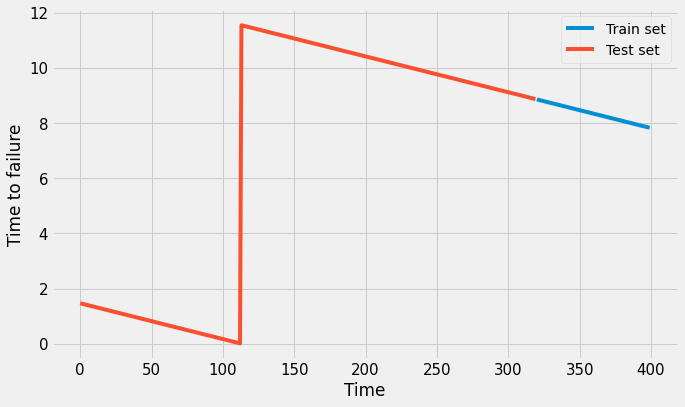

In [126]:
# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(y_test)
plt.plot(y_train)
plt.xlabel('Time')
plt.ylabel('Time to failure')
plt.legend(['Train set', 'Test set'], loc='upper right')
print('Dimension of train data: ',X_train.shape)
print('Dimension of test data: ', X_test.shape)

In [83]:
x_train=X_train.to_numpy()
x_test=X_test.to_numpy()

In [84]:
#Conver to data format needed for modeling
x_train= x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test= x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

In [85]:
print(x_train.shape)
print(x_test.shape)

(320, 1, 165)
(80, 1, 165)


In [95]:
x_test


array([[[4.73100000e+03, 7.94869979e+00, 6.21251602e+00, ...,
         8.12660000e-01, 9.15760000e-01, 1.60000000e-03]],

       [[4.63900000e+03, 7.92387068e+00, 6.19537583e+00, ...,
         7.90800000e-01, 8.92160000e-01, 1.54000000e-03]],

       [[4.70400000e+03, 7.90957141e+00, 6.18586154e+00, ...,
         8.00360000e-01, 8.88520000e-01, 5.22000000e-03]],

       ...,

       [[4.46000000e+03, 7.84858263e+00, 6.14474660e+00, ...,
         8.04260000e-01, 9.15140000e-01, 2.10000000e-03]],

       [[4.52100000e+03, 7.84351670e+00, 6.14008336e+00, ...,
         7.94860000e-01, 8.97660000e-01, 2.86000000e-03]],

       [[4.35600000e+03, 7.76036772e+00, 6.08203029e+00, ...,
         7.72440000e-01, 8.89520000e-01, 3.80000000e-03]]])

In [118]:
# The LSTM model I would like to test
# Note: replace LSTM with GRU or RNN if you want to try those

model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(1,165)))
#model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 1, 50)             43200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 103,701
Trainable params: 103,701
Non-trainable params: 0
_________________________________________________________________
None


In [119]:
model.fit(x_train,y_train,batch_size=512,epochs=10,validation_split=0.05)

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 69.1850 - val_loss: 81.8180
Epoch 2/10
1/1 [==============================] - 0s 26ms/step - loss: 68.5677 - val_loss: 80.9591
Epoch 3/10
1/1 [==============================] - 0s 22ms/step - loss: 67.7599 - val_loss: 80.1080
Epoch 4/10
1/1 [==============================] - 0s 31ms/step - loss: 67.1256 - val_loss: 79.2636
Epoch 5/10
1/1 [==============================] - 0s 26ms/step - loss: 66.6193 - val_loss: 78.4242
Epoch 6/10
1/1 [==============================] - 0s 25ms/step - loss: 65.9184 - val_loss: 77.5896
Epoch 7/10
1/1 [==============================] - 0s 24ms/step - loss: 65.3209 - val_loss: 76.7586
Epoch 8/10
1/1 [==============================] - 0s 27ms/step - loss: 64.7110 - val_loss: 75.9291
Epoch 9/10
1/1 [==============================] - 0s 25ms/step - loss: 64.0795 - val_loss: 75.1003
Epoch 10/10
1/1 [==============================] - 0s 25ms/step - loss: 63.7675 - val_loss: 74.2723


In [120]:

test_output = model.predict(x_test, verbose=0)
y_pred=pd.DataFrame(test_output)
y_test_df=pd.DataFrame(y_test)
print(y_pred)

           0
0   0.346908
1   0.346908
2   0.346908
3   0.346908
4   0.346908
..       ...
75  0.346908
76  0.346908
77  0.346908
78  0.346908
79  0.346908

[80 rows x 1 columns]


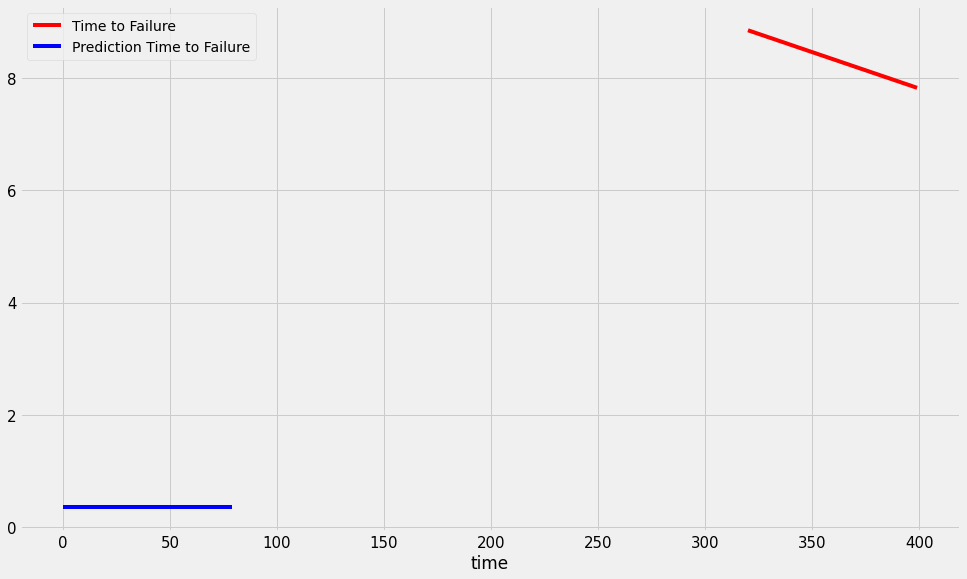

In [121]:
#Visualizing the prediction
plt.figure()
plt.plot(y_test, color = 'r', label = 'Time to Failure')
plt.plot(y_pred, color = 'b', label = 'Prediction Time to Failure')
plt.xlabel('time')
plt.legend()
plt.show()

In [122]:
######RMSE####### Root Mean Squared Error 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 


#RMSE for LSTM Model
err_LSTM = rmse(y_test_df,y_pred)
print('RMSE with LSTM', err_LSTM)

RMSE with LSTM [8.00012696]


## Modeling LSTM, GRU, and Bidirectional networks

In [129]:
# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,                             
              return_sequences=True),
              input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model
# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    model.add(m (units = units, return_sequences = True,
                input_shape = [x_train.shape[1], x_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(m (units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model
# BiLSTM
model_bilstm = create_model_bilstm(64)
# GRU and LSTM
model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)


In [132]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(x_train, y_train, epochs = 100,  
                        validation_split = 0.2, batch_size = 32, 
                        shuffle = False, callbacks = [early_stop])
    return history
history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

#tensorflow.keras.callbacks.EarlyStopping(monitor = 'val_loss',

Epoch 1/100
8/8 [==============================] - 5s 152ms/step - loss: 56.6111 - val_loss: 69.7567
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 47.0781 - val_loss: 55.3830
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 38.4928 - val_loss: 41.8334
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 31.5959 - val_loss: 30.2784
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 26.9679 - val_loss: 21.5007
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 24.5318 - val_loss: 15.5391
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 23.6528 - val_loss: 11.8699
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 23.5740 - val_loss: 9.8042
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 23.7539 - val_loss: 8.7547
Epoch 10/100
8/8 [==============================] - 0s 5ms/step - loss: 23.9326 - val_loss: 8.3056
Epoch 11/1

# Plot train loss and validation loss

Evaluate the model performance in prediction

In [139]:
# Plot train loss and validation loss
def plot_loss (history,title):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.title(title)



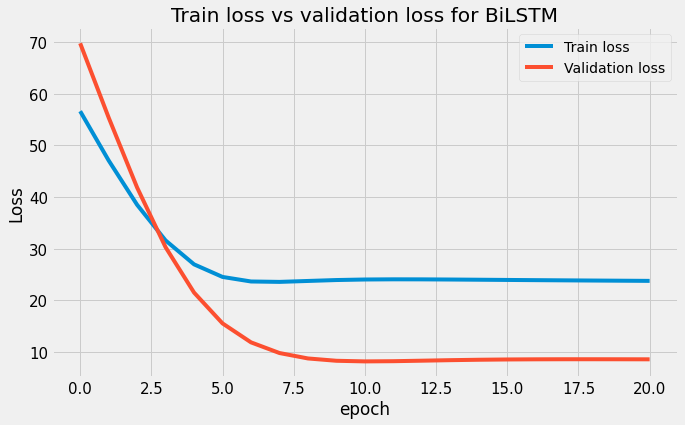

In [140]:
plot_loss (history_bilstm,'Train loss vs validation loss for BiLSTM')

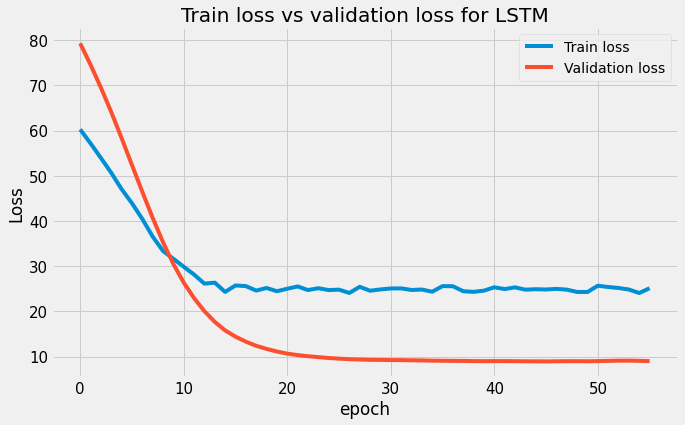

In [141]:
plot_loss (history_lstm,'Train loss vs validation loss for LSTM')

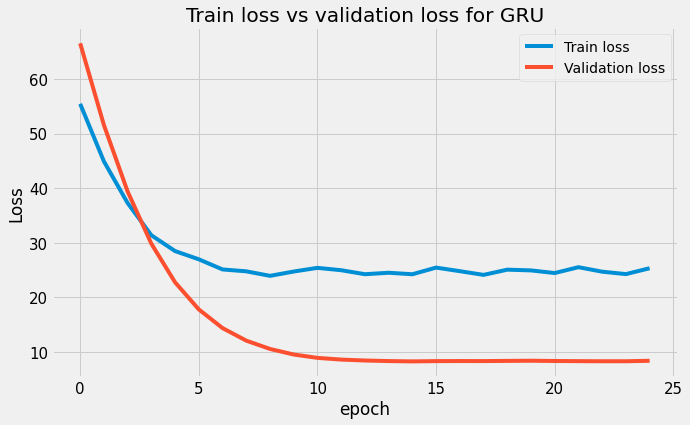

In [142]:
plot_loss (history_gru,'Train loss vs validation loss for GRU')

# Make prediction using BiLSTM, LSTM and GRU


Here I predict UWC using BiLSTM, LSTM and GRU models. Then, I plot true future (test data) vs prediction the three models.

In [144]:
x_test.shape

(80, 1, 165)

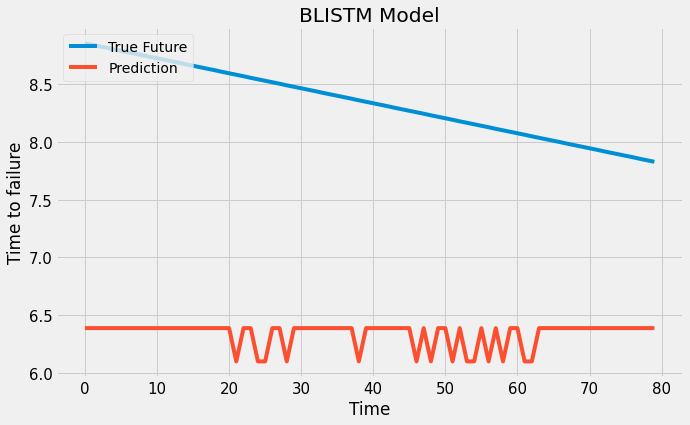

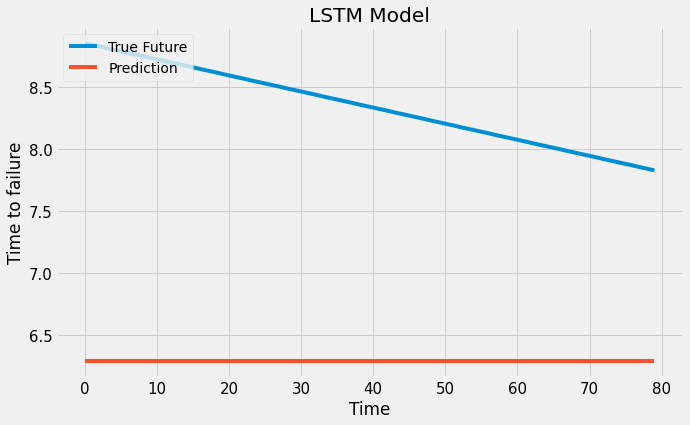

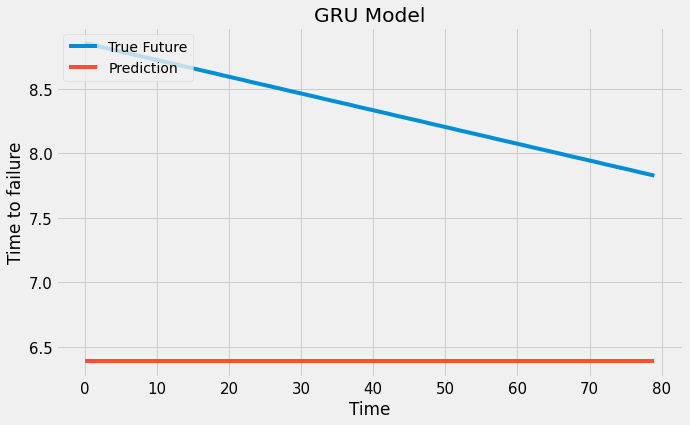

In [151]:
# Make prediction
def prediction(model):
    prediction = model.predict(x_test)
   # prediction = scaler_y.inverse_transform(prediction)
    return prediction
prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)
# Plot true future vs prediction
def plot_future(prediction, y_test,title):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='True Future')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction')
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Time to failure')
    plt.title(title)
plot_future(prediction_bilstm, y_test,"BLISTM Model")
plot_future(prediction_lstm, y_test,"LSTM Model")
plot_future(prediction_gru, y_test,"GRU Model")

# Calculate RMSE and MAE


Let me use two goodness-of-fit measure to evaluate the performance of the models.

In [150]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}',mae)
    print('Root Mean Square Error: {:.4f}',rmse)
    print('')
evaluate_prediction(prediction_bilstm, y_test_df, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test_df, 'LSTM')
evaluate_prediction(prediction_gru, y_test_df, 'GRU')

Bidirectional LSTM:
Mean Absolute Error: {:.4f} time_to_failure    2.003203
dtype: float64
Root Mean Square Error: {:.4f} time_to_failure    2.026822
dtype: float64

LSTM:
Mean Absolute Error: {:.4f} time_to_failure    2.055386
dtype: float64
Root Mean Square Error: {:.4f} time_to_failure    2.077152
dtype: float64

GRU:
Mean Absolute Error: {:.4f} time_to_failure    1.953324
dtype: float64
Root Mean Square Error: {:.4f} time_to_failure    1.976214
dtype: float64

